In [86]:
import numpy as np
import cv2
cv = cv2
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pandas as pd

In [10]:
#https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def make_mask(row_id, df):
    '''Given a row index, return image_id and mask (256, 1600, 4)'''
    fname = df.iloc[row_id].name
    labels = df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.float32) # float32 is V.Imp
    # 4:class 1～4 (ch:0～3)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 1
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return fname, masks

In [66]:
data_dir = Path('dataset/train_images')

In [12]:
paths = list(Path(data_dir).glob('*'))

In [74]:
df = pd.read_csv('dataset/train.csv')
df['ImageId'], df['ClassId'] = zip(*df['ImageId_ClassId'].str.split('_'))
df['ImageId'] = df['ImageId'].apply(lambda x: data_dir.joinpath(x))
df['ClassId'] = df['ClassId'].astype(int)
df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
df['defects'] = df.count(axis=1)
df.head()

ClassId                                                                             1  \
ImageId                                                                                 
dataset/train_images/0002cc93b.jpg  29102 12 29346 24 29602 24 29858 24 30114 24 3...   
dataset/train_images/00031f466.jpg                                                NaN   
dataset/train_images/000418bfc.jpg                                                NaN   
dataset/train_images/000789191.jpg                                                NaN   
dataset/train_images/0007a71bf.jpg                                                NaN   

ClassId                               2  \
ImageId                                   
dataset/train_images/0002cc93b.jpg  NaN   
dataset/train_images/00031f466.jpg  NaN   
dataset/train_images/000418bfc.jpg  NaN   
dataset/train_images/000789191.jpg  NaN   
dataset/train_images/0007a71bf.jpg  NaN   

ClassId                                                                             3  \
ImageId                                                                                 
dataset/train_images/0002cc93b.jpg                                                NaN   
dataset/train_images/00031f466.jpg                                                NaN   
dataset/train_images/000418bfc.jpg                                                NaN   
dataset/train_images/000789191.jpg                                                NaN   
dataset/train_images/0007a71bf.jpg  18661 28 18863 82 19091 110 19347 110 19603 11...   

ClassId                               4  defects  
ImageId                                           
dataset/train_images/0002cc93b.jpg  NaN        1  
dataset/train_images/00031f466.jpg  NaN        0  
dataset/train_images/000418bfc.jpg  NaN        0  
dataset/train_images/000789191.jpg  NaN        0  
dataset/train_images/0007a71bf.jpg  NaN        1

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12568 entries, dataset/train_images/0002cc93b.jpg to dataset/train_images/ffffd67df.jpg
Data columns (total 5 columns):
1          897 non-null object
2          247 non-null object
3          5150 non-null object
4          801 non-null object
defects    12568 non-null int64
dtypes: int64(1), object(4)
memory usage: 589.1+ KB


In [76]:
df.describe(include='all')

ClassId                                                  1  \
count                                                  897   
unique                                                 897   
top      18163 7 18419 14 18675 14 18931 14 19187 14 19...   
freq                                                     1   
mean                                                   NaN   
std                                                    NaN   
min                                                    NaN   
25%                                                    NaN   
50%                                                    NaN   
75%                                                    NaN   
max                                                    NaN   

ClassId                                                  2  \
count                                                  247   
unique                                                 247   
top      123839 15 124065 45 124291 76 124532 91 124788...   
freq                                                     1   
mean                                                   NaN   
std                                                    NaN   
min                                                    NaN   
25%                                                    NaN   
50%                                                    NaN   
75%                                                    NaN   
max                                                    NaN   

ClassId                                                  3  \
count                                                 5150   
unique                                                5150   
top      90079 1 90334 2 90589 3 90844 4 91099 6 91354 ...   
freq                                                     1   
mean                                                   NaN   
std                                                    NaN   
min                                                    NaN   
25%                                                    NaN   
50%                                                    NaN   
75%                                                    NaN   
max                                                    NaN   

ClassId                                                  4       defects  
count                                                  801  12568.000000  
unique                                                 801           NaN  
top      104789 3 105043 7 105298 9 105552 11 105806 13...           NaN  
freq                                                     1           NaN  
mean                                                   NaN      0.564529  
std                                                    NaN      0.560757  
min                                                    NaN      0.000000  
25%                                                    NaN      0.000000  
50%                                                    NaN      1.000000  
75%                                                    NaN      1.000000  
max                                                    NaN      3.000000

In [77]:
df.groupby('defects').size()

defects
0    5902
1    6239
2     425
3       2
dtype: int64

# Look at masks

In [78]:
palet = [(249, 192, 12), (0, 185, 241), (114, 0, 218), (249,50,12)]

In [172]:
def name_and_mask(row):
    mask = np.zeros((256, 1600, 4), dtype=np.uint8)

    for idx in range(1, 5):
        label = row[idx]
        if label is not np.nan:
            mask_label = np.zeros(1600*256, dtype=np.uint8)
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            for pos, le in zip(positions, length):
                mask_label[pos-1:pos+le-1] = 1
            mask[:, :, idx - 1] = mask_label.reshape(256, 1600, order='F')
    return mask

In [173]:
def show_mask_image(row):
    path = row.Index
    img = cv2.imread(str(path))
    mask = name_and_mask(row)
    fig, ax = plt.subplots(figsize=(15, 15))

    for ch in range(4):
        contours, _ = cv2.findContours(mask[:, :, ch], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        for i in range(0, len(contours)):
            cv2.polylines(img, contours[i], True, palet[ch], 2)
    ax.set_title(path)
    ax.imshow(img)
    plt.show()

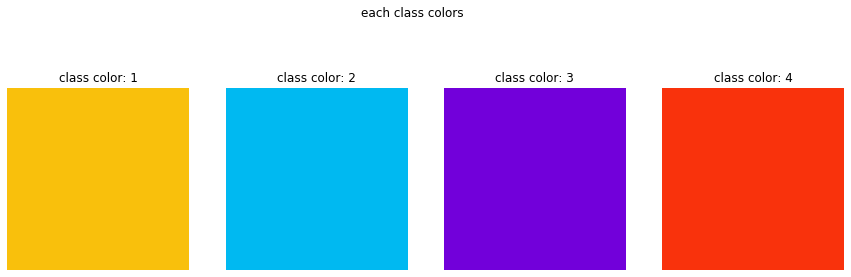

In [174]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(np.ones((50, 50, 3), dtype=np.uint8) * palet[i])
    ax[i].set_title("class color: {}".format(i+1))
fig.suptitle("each class colors")

plt.show()

In [182]:
def show_cls(count, cls=None):
    if cls is None:
        sub_df = df[df['defects'] == 0]
    else:
        try:
            sub_df = df.dropna(subset=[cls])
        except KeyError:
            sub_df = df.dropna(subset=cls)
        
    for row in sub_df.sample(min(count, len(sub_df))).itertuples():
        show_mask_image(row)

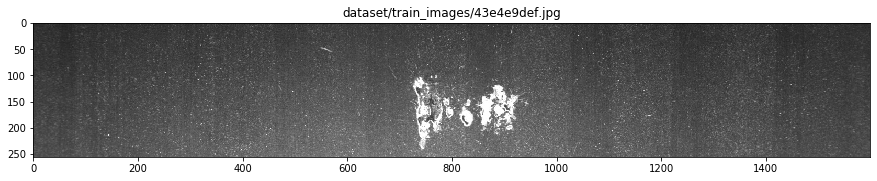

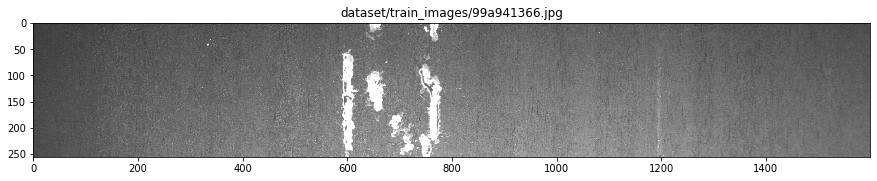

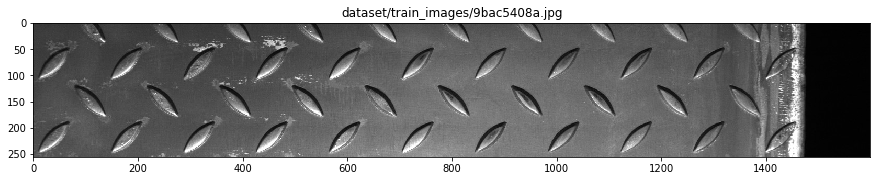

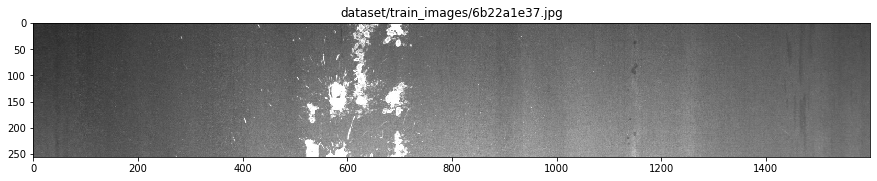

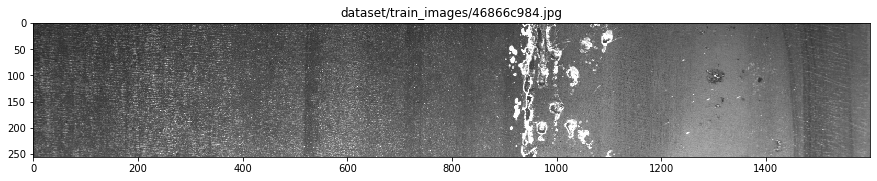

In [176]:
show_cls(5)

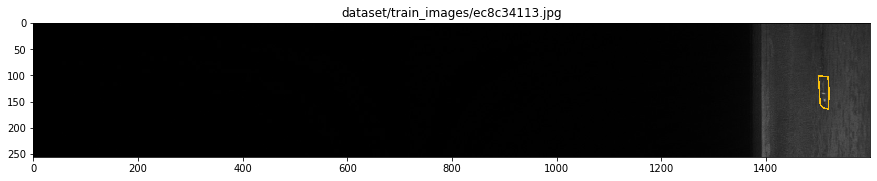

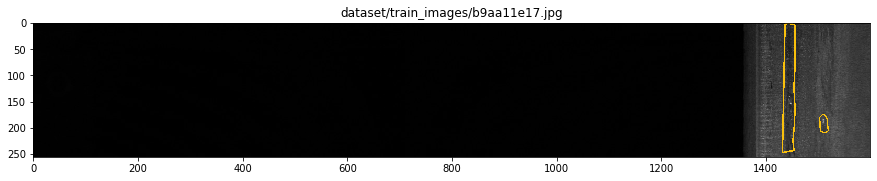

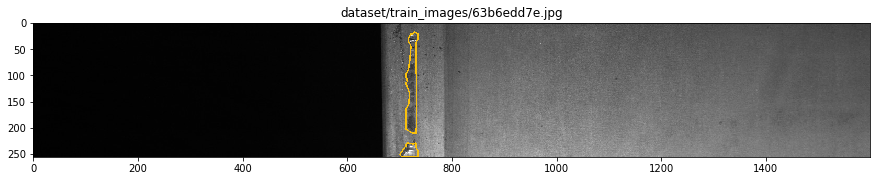

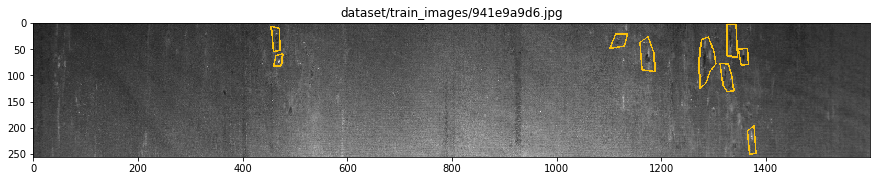

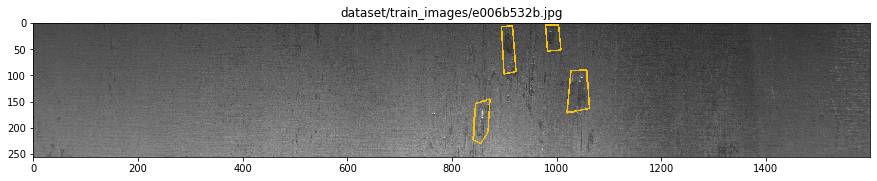

In [177]:
show_cls(5, 1)

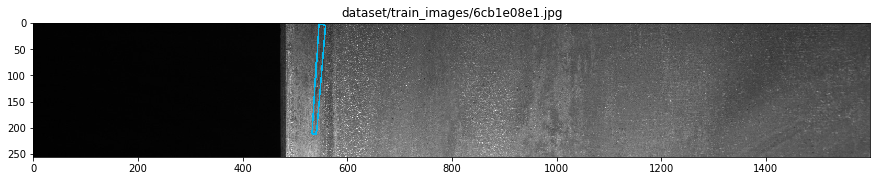

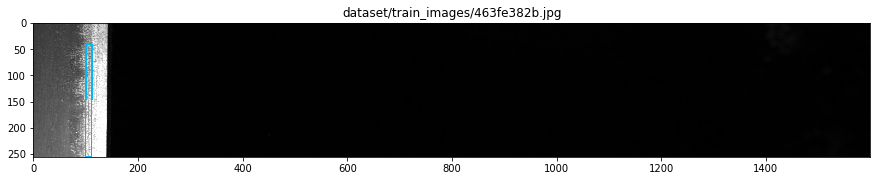

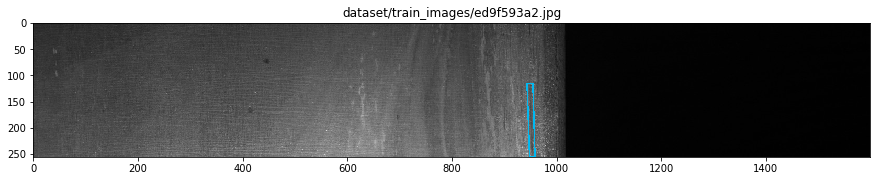

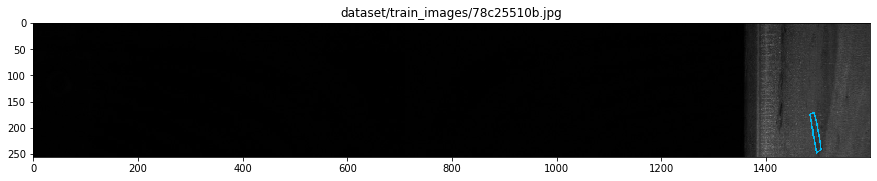

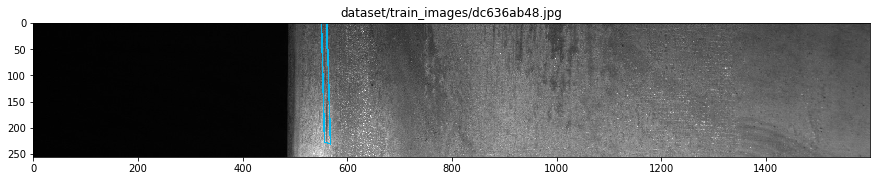

In [178]:
show_cls(5, 2)

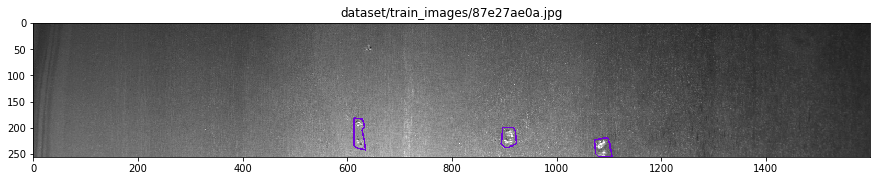

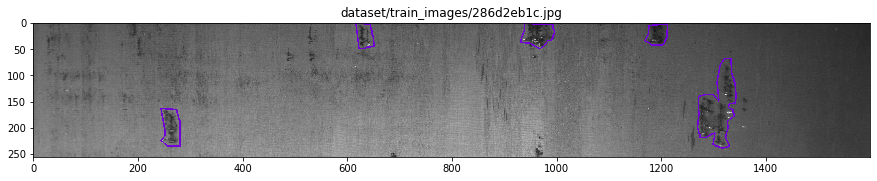

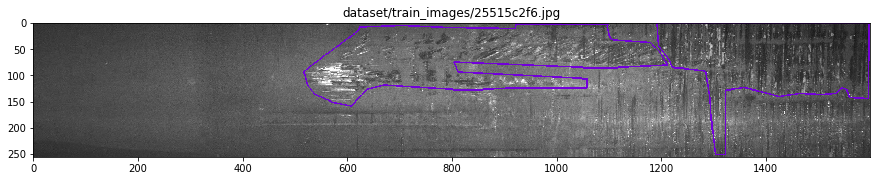

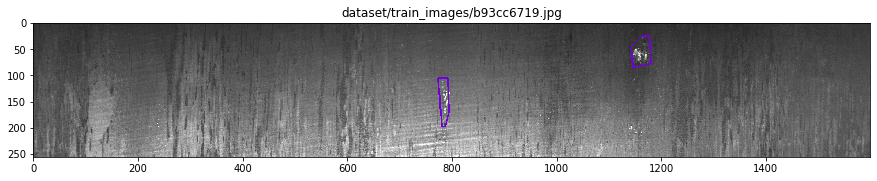

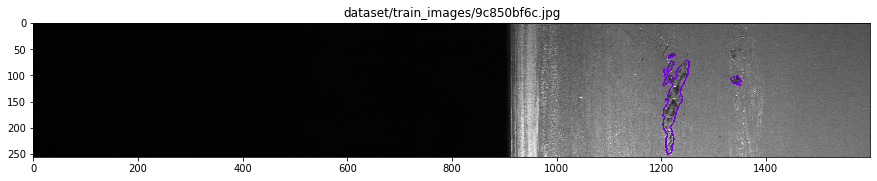

In [179]:
show_cls(5, 3)

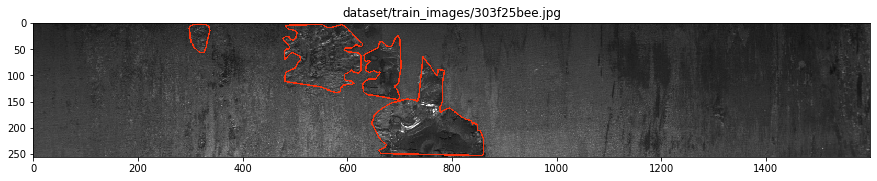

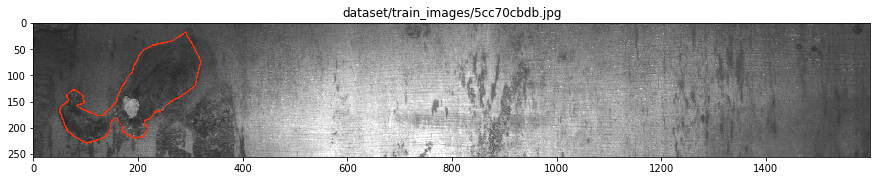

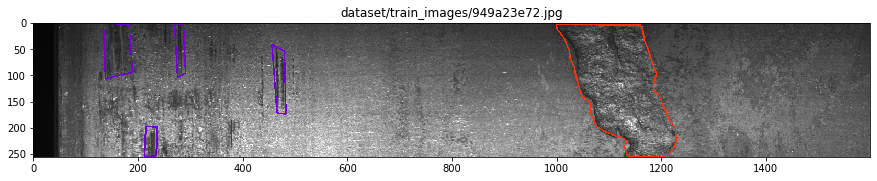

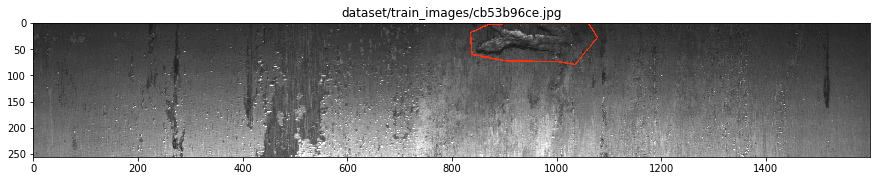

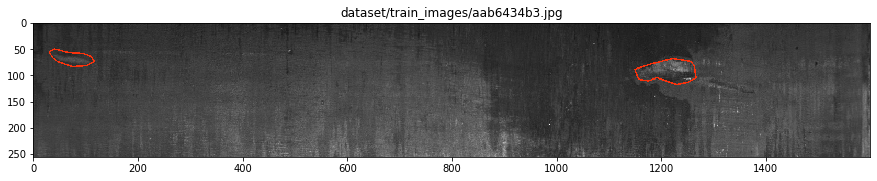

In [180]:
show_cls(5, 4)

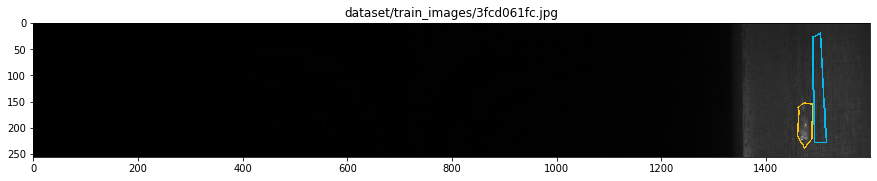

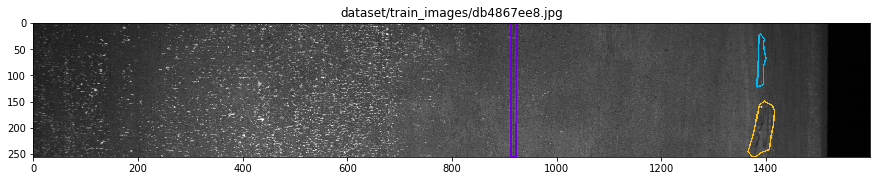

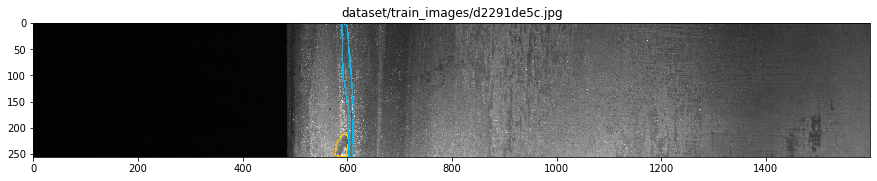

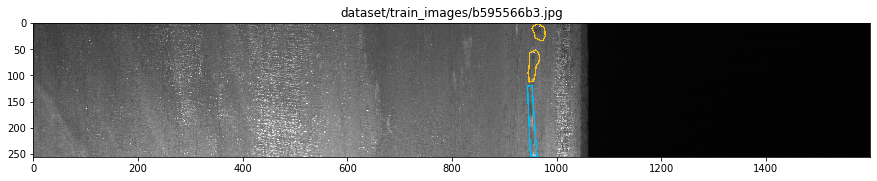

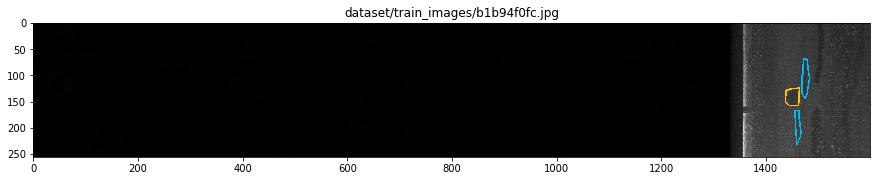

In [183]:
show_cls(5, [1, 2])

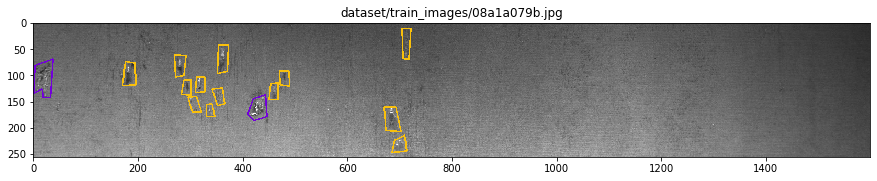

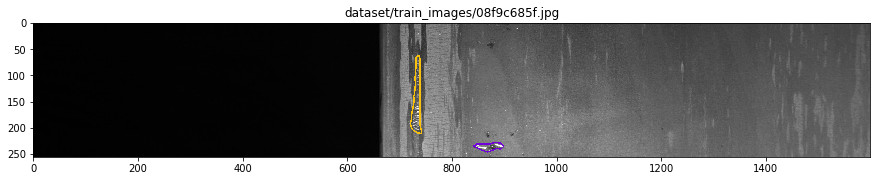

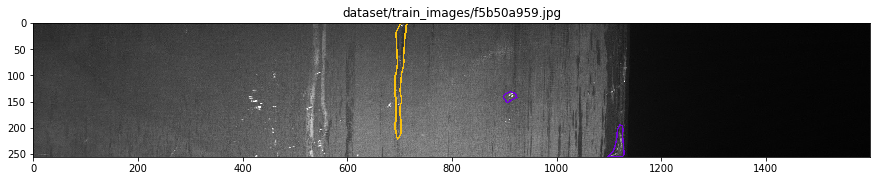

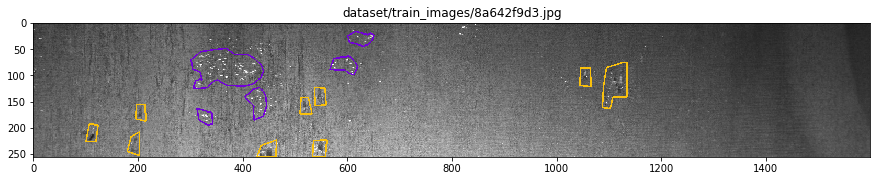

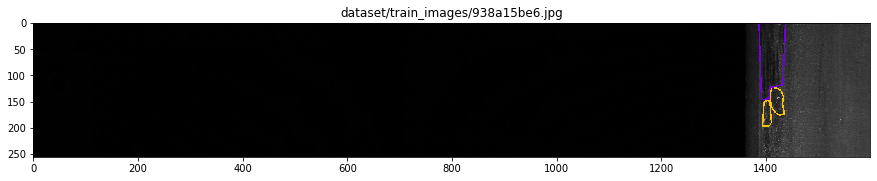

In [184]:
show_cls(5, [1, 3])

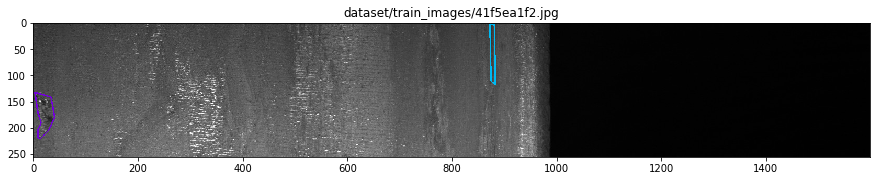

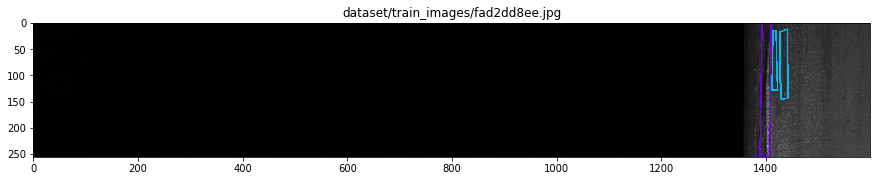

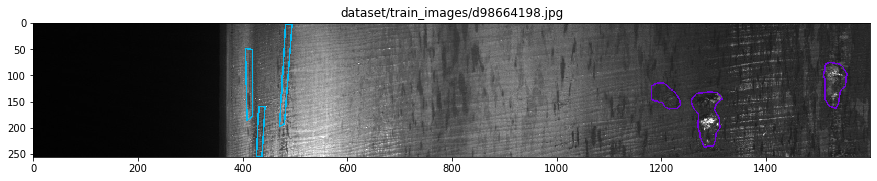

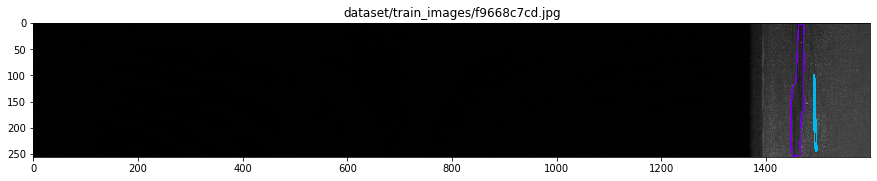

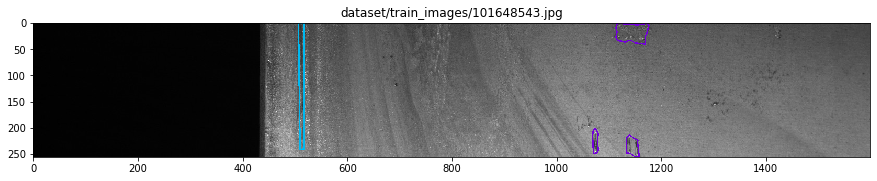

In [186]:
show_cls(5, [2, 3])

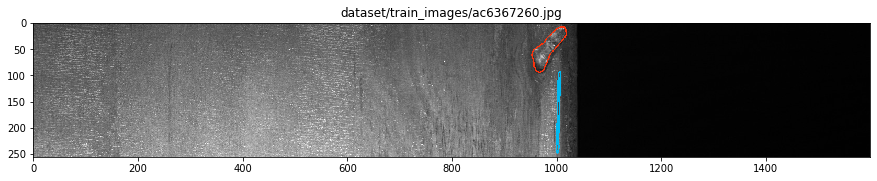

In [187]:
show_cls(5, [2, 4])

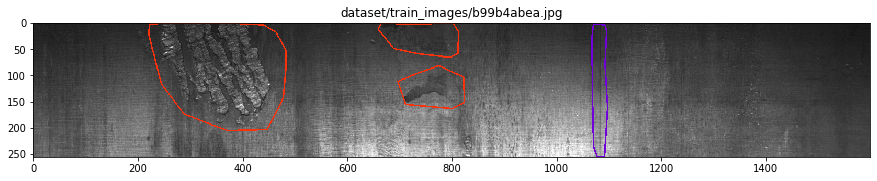

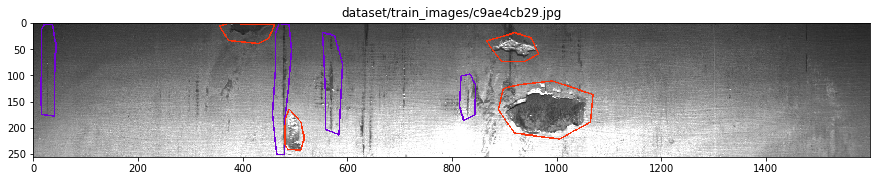

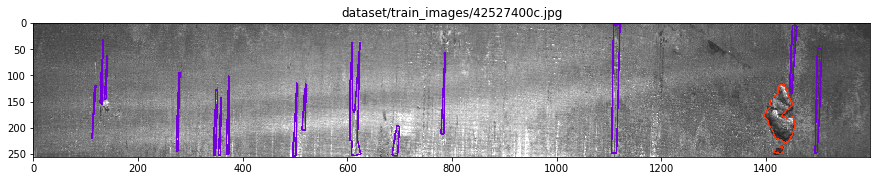

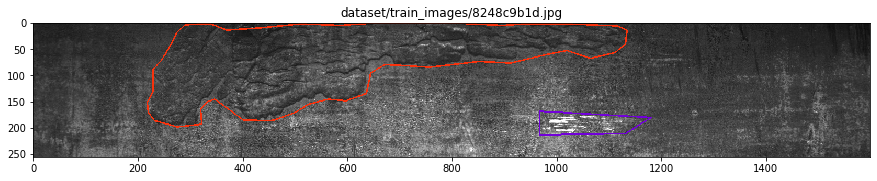

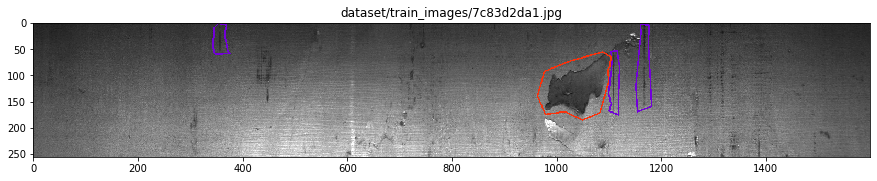

In [188]:
show_cls(5, [3, 4])

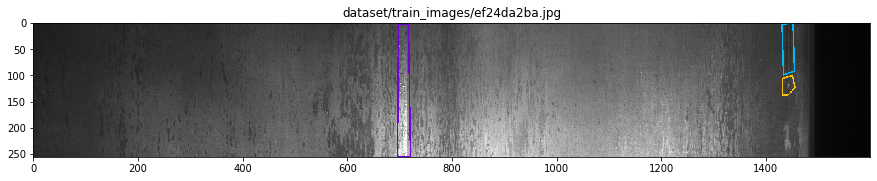

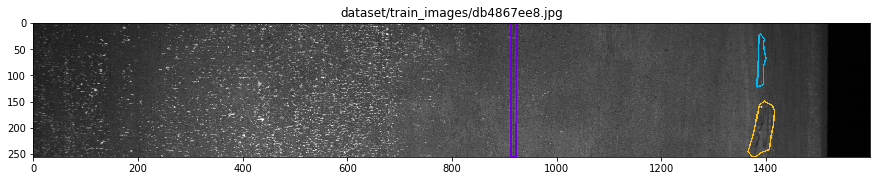

In [189]:
show_cls(5, [1, 2, 3])

In [191]:
len(df.dropna(subset=[1, 2]))

37

In [192]:
len(df.dropna(subset=[1, 3]))

93

In [193]:
len(df.dropna(subset=[1, 4]))

0

In [194]:
len(df.dropna(subset=[2, 3]))

16

In [195]:
len(df.dropna(subset=[2, 4]))

1

In [196]:
len(df.dropna(subset=[1, 2, 3]))

2